In [1]:
from auditor import *

### User defined inputs ###

In [2]:
# Identify filenames for control, treatment and demographic information

control_ = "HRo1" #Raw text resume input
control_file = './Personality Prediction AI/data/'+control_+'.csv'

treatment_dict = { 
                'HRi1': 'De-Identified Resume', 
                'HRi2': 'De-Identified Resume', 
                'HRi3': 'De-Identified REsume', 
                'HRd1': 'DOCX Resume', 
                'HRu1': 'URL-Embedded Resume', 
                'HL1': 'LinkedIn', 
                'HL2': 'LinkedIn', 
                'HT1': 'Twitter', 
                'HT2': 'Twitter'}

demographic_data_filename = "./Personality Prediction AI/data/survey.csv"

#Demographic information of interest:
groups_of_interest = {"gender": ["Female"], "race": ["White", "Asian"], "birth_country": ["India", "USA"]}

# Define the score_names (target labels) and the primary key between control, treatments and demographic information
score_names = ['Dominance', 'Influence', 'Steadiness', 'DiSC Calculativeness']
primary_key = 'Participant_ID'

### Load the data: control and treatment inputs ###

In [3]:
control_input_df = pd.read_csv(control_file, index_col=primary_key)
control_input_df.head()

,Dominance,Influence,Steadiness,DiSC Calculativeness,Openness,Big Five Conscientiousness,Extraversion,Agreeableness,Emotional Stability,Attitude and Outlook,Need for Autonomy,Teamwork Skills,General Behavior,Action Orientedness,Stability Potential,Learning Ability,Confidence Score,output_success
Participant_ID,,,,,,,,,,,,,,,,,,
ID49,7.4,4.7,3.3,6.7,6.06,5.67,2.78,4.89,6.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.0,False
ID2,3.1,4.3,9.3,9.2,5.71,7.22,5.32,7.25,6.35,6.8,6.9,6.2,7.5,5.4,6.2,6.0,100.0,True
ID3,6.4,5.1,6.0,8.3,5.93,5.82,4.01,5.43,5.94,5.3,5.7,5.2,5.8,4.4,8.3,4.9,59.1,True
ID4,6.6,5.4,5.2,6.6,6.17,6.51,5.35,6.63,4.03,4.7,5.0,4.5,4.5,6.2,6.0,6.5,100.0,True
ID5,6.1,4.7,4.9,7.8,5.80,5.07,5.89,5.25,5.01,5.1,5.1,4.4,4.9,5.0,6.4,6.7,100.0,True


In [4]:
treatment_input = {}
for treatment_ in treatment_dict.keys():
    treatment_file = './Personality Prediction AI/data/'+treatment_+'.csv'
    treatment_input[treatment_dict[treatment_]] = pd.read_csv(treatment_file, index_col=primary_key)

### Load demographic data ###

In [5]:
demographic_df = pd.read_csv(demographic_data_filename, index_col=primary_key)

In [6]:
demographic_df.head()

,gender,race,birth_country,primary_language,resume,linkedin,twitter,linkedin_in_orig_resume,orig_embed_type,orig_file_type
Participant_ID,,,,,,,,,,
ID2,Male,Asian,USA,English,True,True,False,True,Full url hyperlinked,pdf
ID3,Male,Asian,USA,English,True,True,False,False,NaN,pdf
ID4,Male,Asian,India,Other Language,True,True,True,False,NaN,pdf
ID5,Male,White,Other Country,English,True,True,False,True,Full url hyperlinked,docx
ID6,Male,White,USA,English,True,True,False,True,Full url hyperlinked,pdf


### Only retaining IDs that exist in the control and all treatments

In [7]:
# We cannot compare scores if IDs are missing across treatments

ID_ = []

for treatment in treatment_input.keys():
    ID_.append(set(set.intersection(set(control_input_df.index), set(treatment_input[treatment].index))))
    
ID_list = list(set.intersection(*ID_))

In [8]:
demographic_df = demographic_df.loc[ID_list]
control_input_df = control_input_df.loc[ID_list]

for treatment in treatment_input.keys():
    treatment_input[treatment] = treatment_input[treatment].loc[ID_list]

### Hit the ADS to get scores for control and treatments ###

In [9]:
ADS_blackbox = ADS(score_names, primary_key)

This is an example of an external audit -- we only have blackbox access to the ADS, so the score function we will use here is a simple look-up. The "feature" X here is simply the primary ID that identifies a record

In [10]:
control_scores = ADS_blackbox.score(X=ID_list, score_func=functools.partial(ADS_lookup, filename=control_file))
control_scores.head()

,Dominance,Influence,Steadiness,DiSC Calculativeness
Participant_ID,,,,
ID13,5.3,4.0,6.5,6.8
ID86,5.1,7.9,4.5,3.7
ID85,7.8,4.4,6.3,5.9
ID36,5.0,5.9,6.0,6.7
ID55,4.1,6.0,6.4,8.6


In [11]:
treatment_scores = {}
for treatment_ in treatment_dict.keys():
    treatment_file = './Personality Prediction AI/data/'+treatment_+'.csv'
    treatment_scores[treatment_dict[treatment_]] = ADS_blackbox.score(X=ID_list, score_func=functools.partial(ADS_lookup, filename=treatment_file))

## Auditing the stability of the scores for different treatments ##

### Instantiate the Auditor class ###

In [12]:
stability_audit = Auditor(score_names, primary_key, control_scores, 
                          treatment_scores, demographic_df, groups_of_interest)

### Visualizing scores for control and treatment 

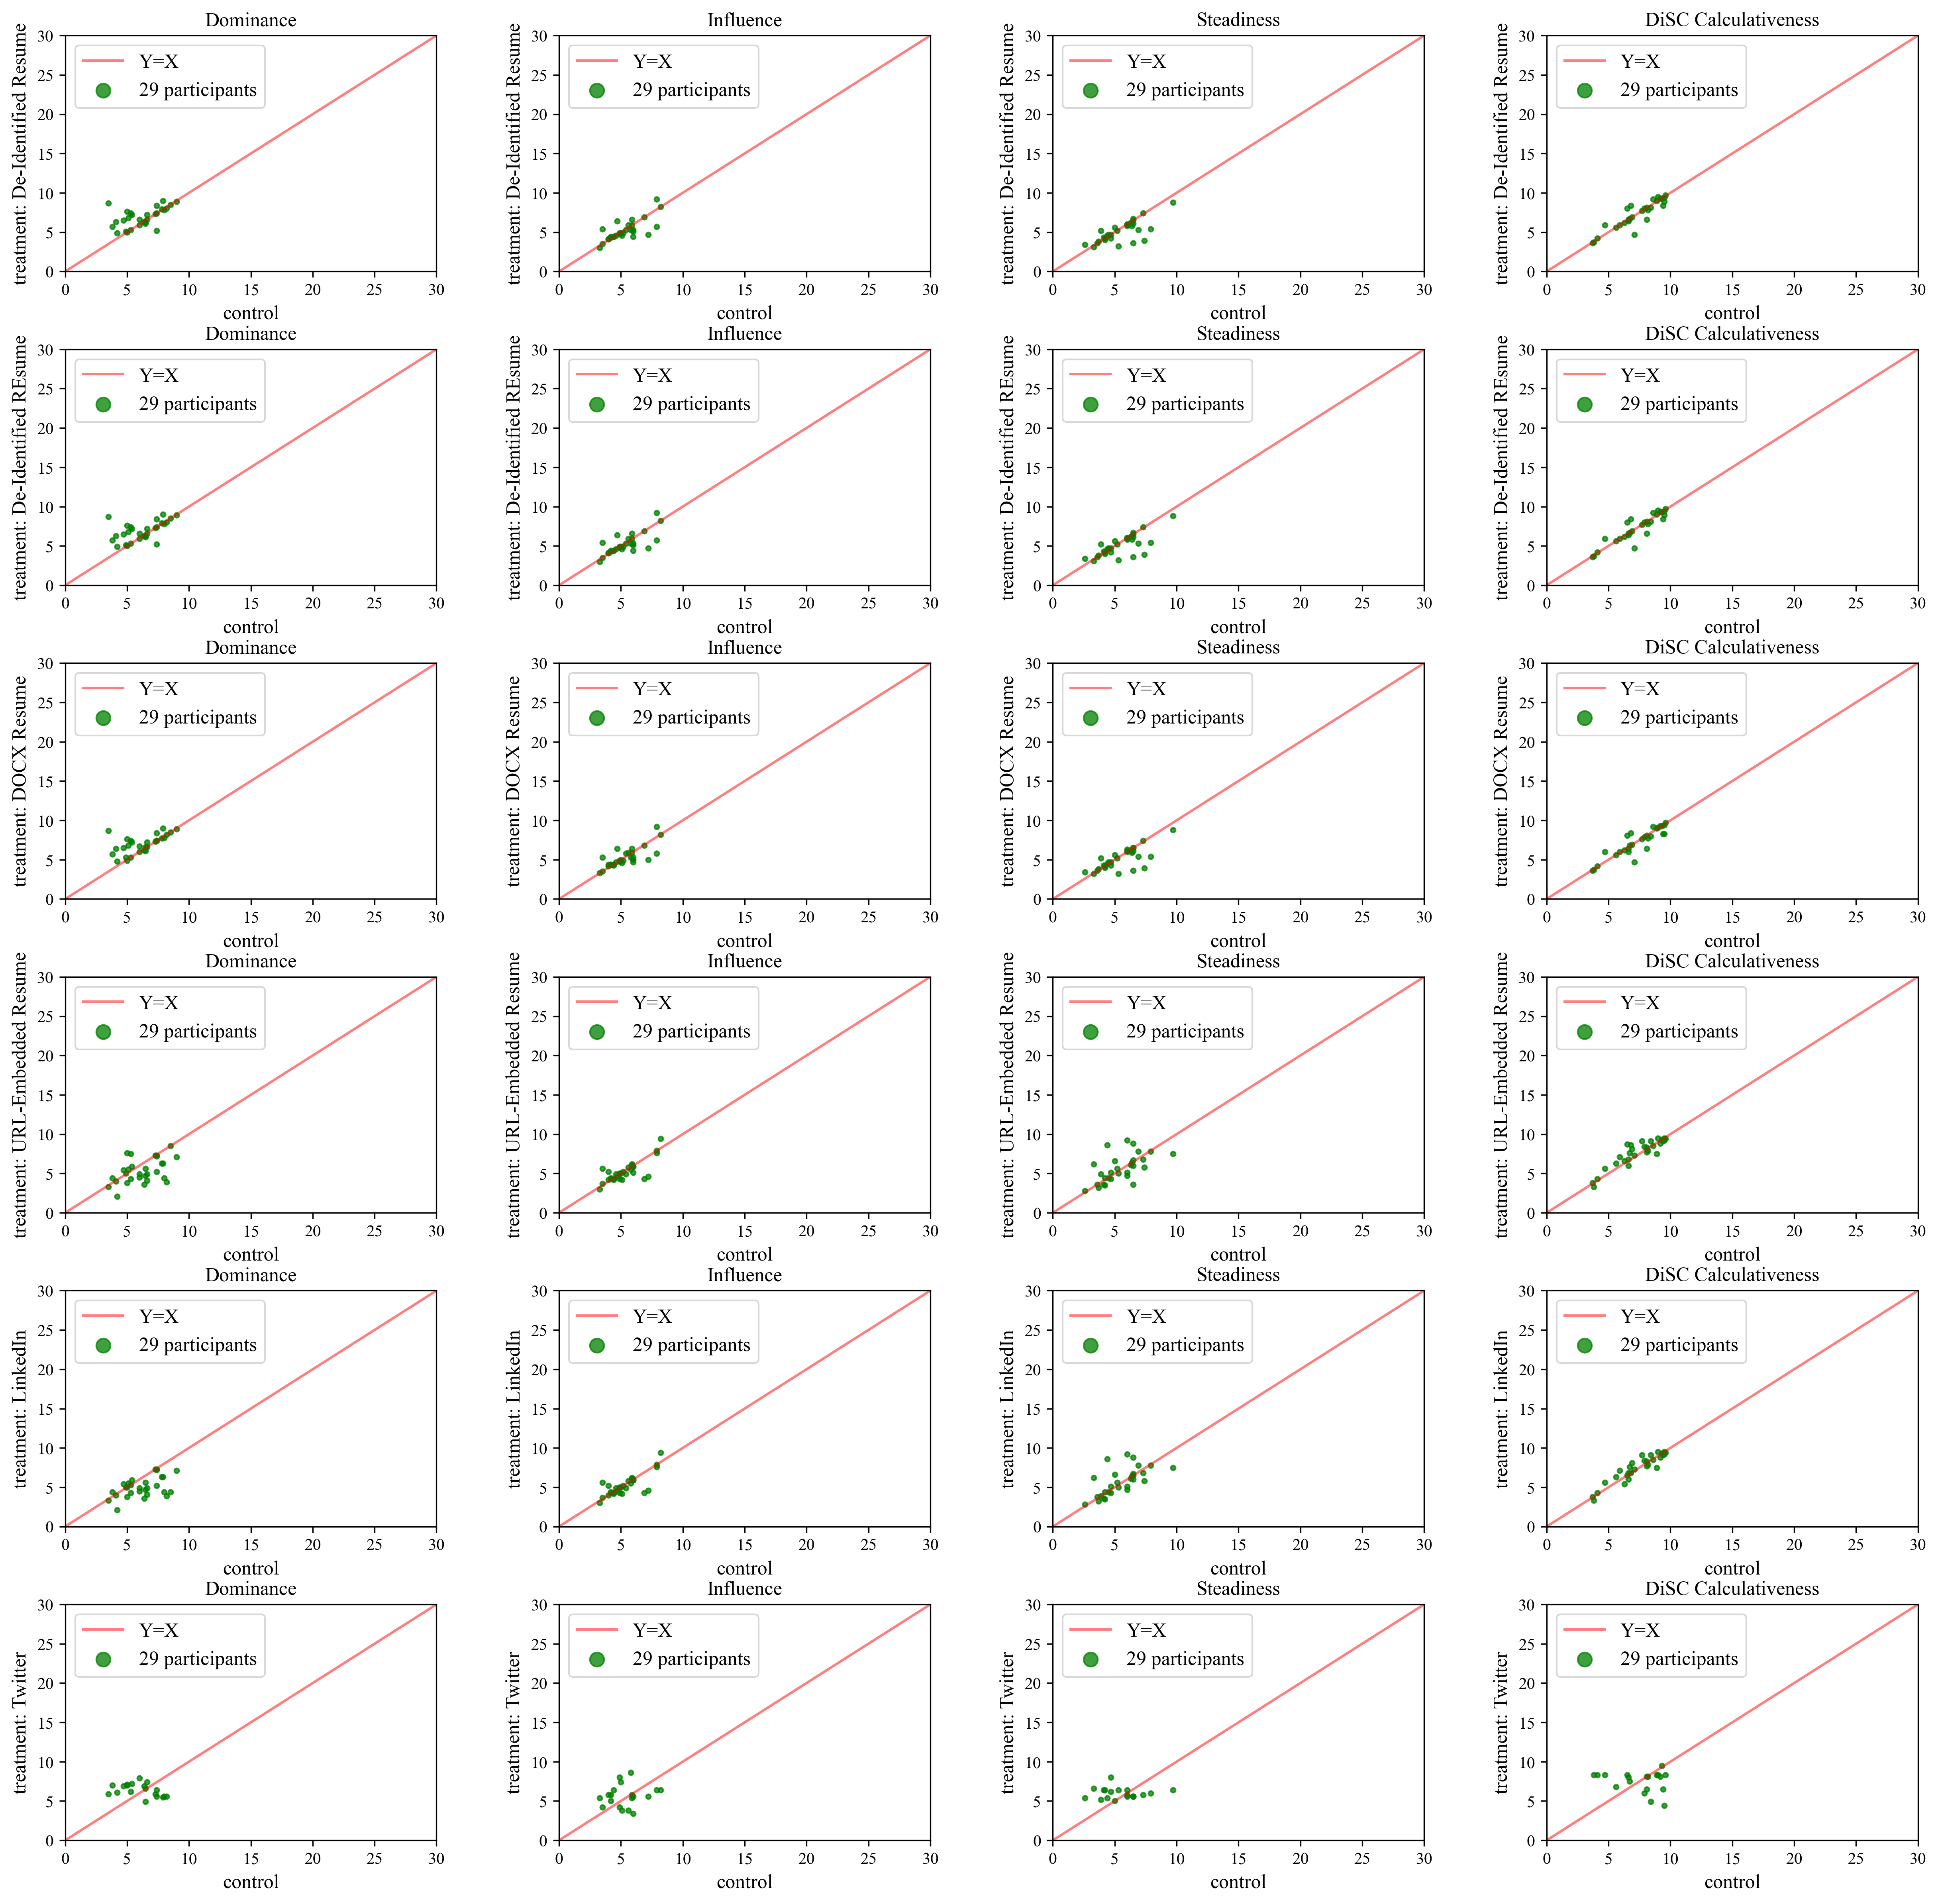

In [13]:
stability_audit.visualize_scores(axislim=30)

### Total change between control and treatment as a measure of stability ###

In [14]:
stability_audit.compute_total_variation()

Dominance  Influence  \
De-Identified Resume overall__            mean   0.934483   0.558621   
                                          std    1.185109   0.742831   
                     gender_Female        mean   0.744444   0.666667   
                                          std    0.793900   0.847054   
                     gender_others        mean   1.020000   0.510000   
...                                                   ...        ...   
Twitter              birth_country_India  std    0.715808   0.987783   
                     birth_country_USA    mean   1.325000   1.200000   
                                          std    0.766718   0.602376   
                     birth_country_others mean   1.800000   2.325000   
                                          std    0.648074   0.660177   

                                                Steadiness  \
De-Identified Resume overall__            mean    0.668966   
                                          std     0.953978   
                     gender_Female        mean    0.511111   
                                          std     0.786518   
                     gender_others        mean    0.740000   
...                                                    ...   
Twitter              birth_country_India  std     1.186632   
                     birth_country_USA    mean    1.312500   
                                          std     0.997765   
                     birth_country_others mean    1.725000   
                                          std     1.217580   

                                                DiSC Calculativeness  
De-Identified Resume overall__            mean              0.437931  
                                          std               0.628157  
                     gender_Female        mean              0.377778  
                                          std               0.454911  
                     gender_others        mean              0.465000  
...                                                              ...  
Twitter              birth_country_India  std               1.363644  
                     birth_country_USA    mean              2.500000  
                                          std               1.939072  
                     birth_country_others mean              1.225000  
                                          std               0.830161  

[108 rows x 4 columns]

### Visualizing the total change (L1 norm)

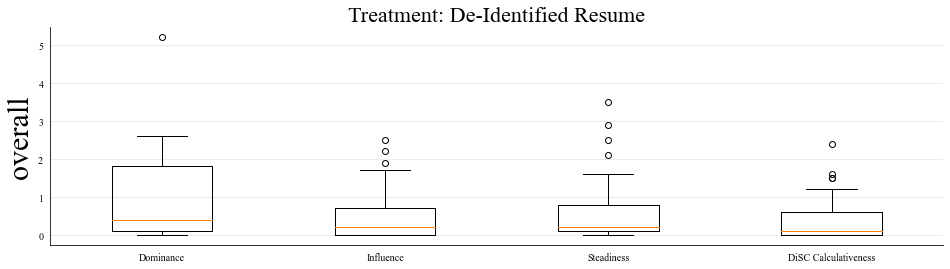

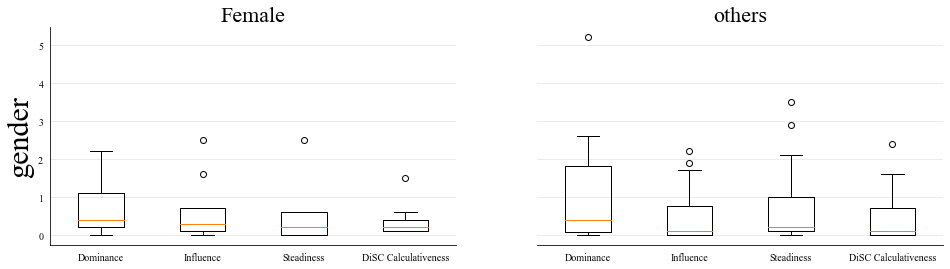

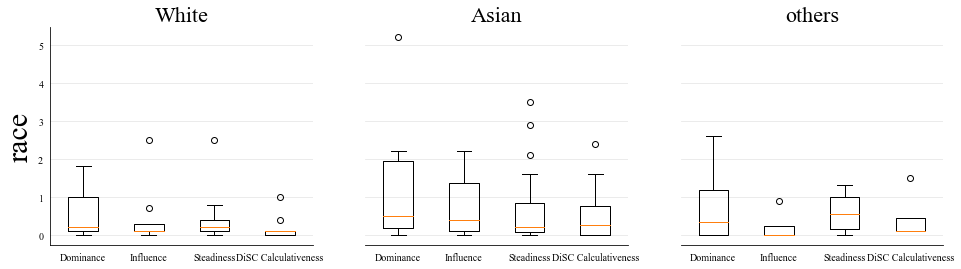

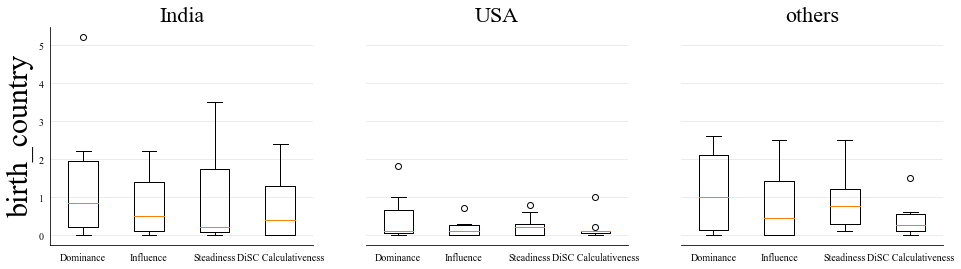

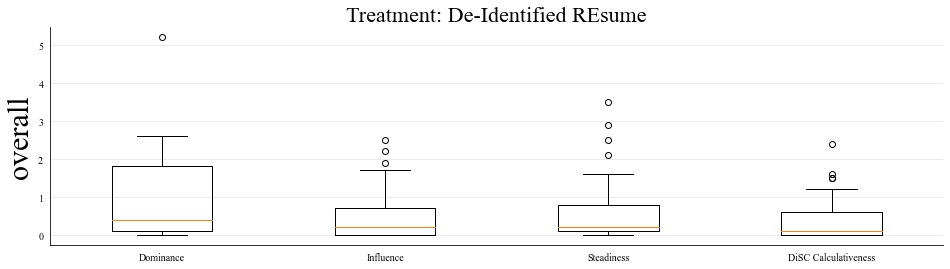

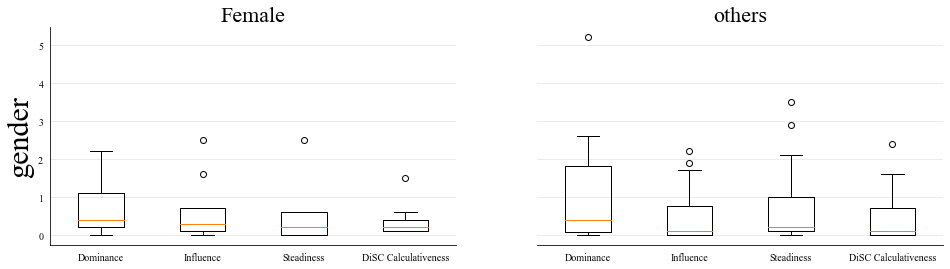

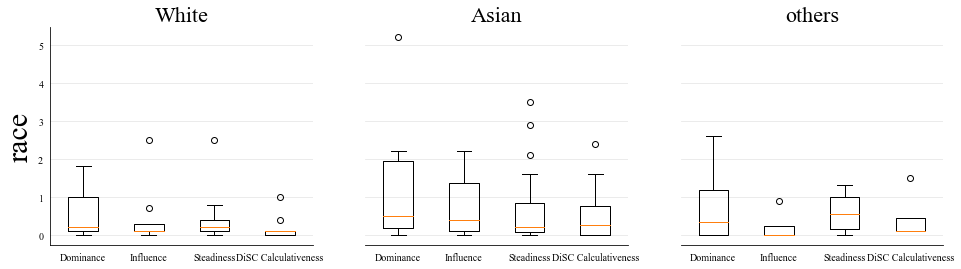

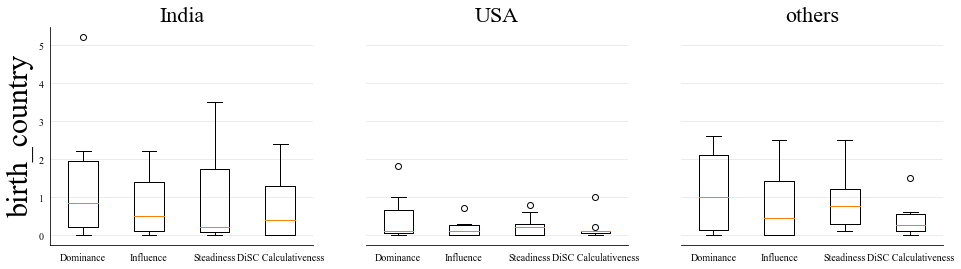

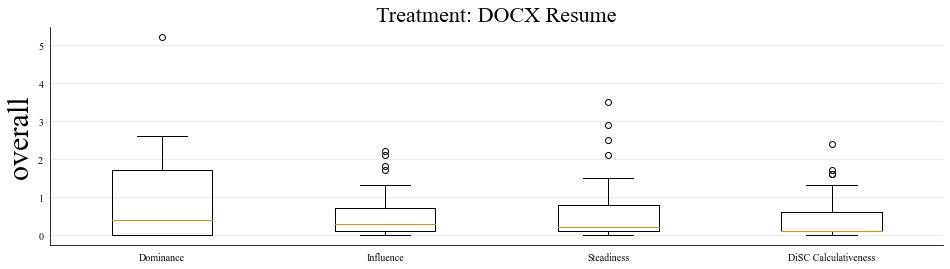

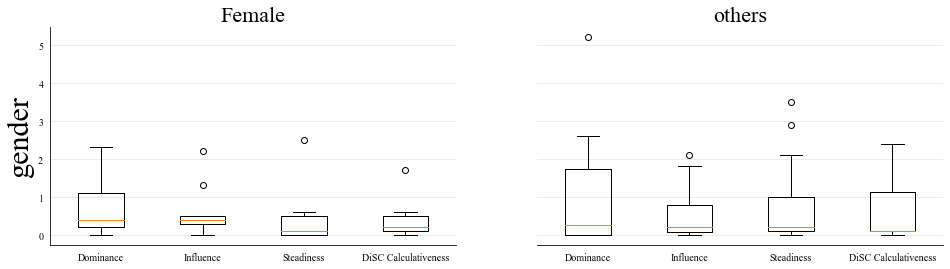

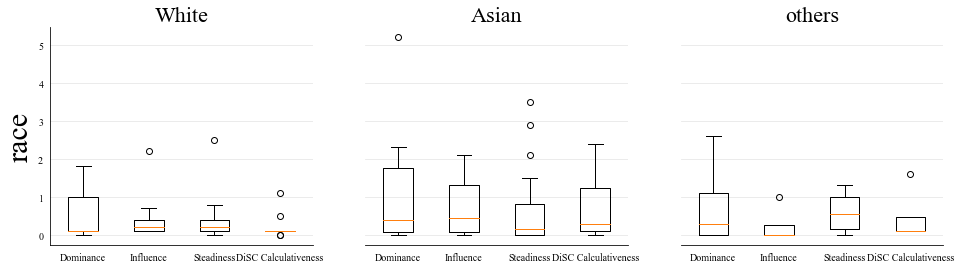

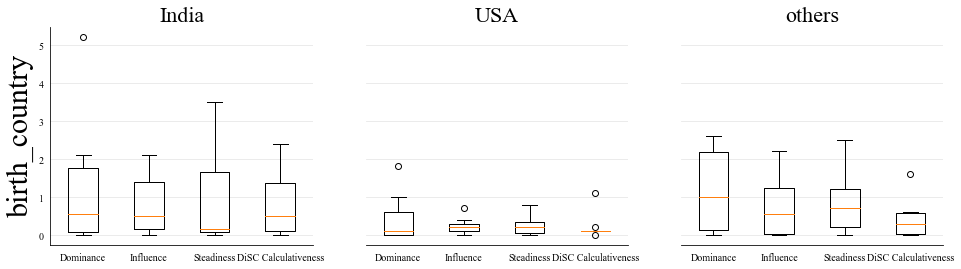

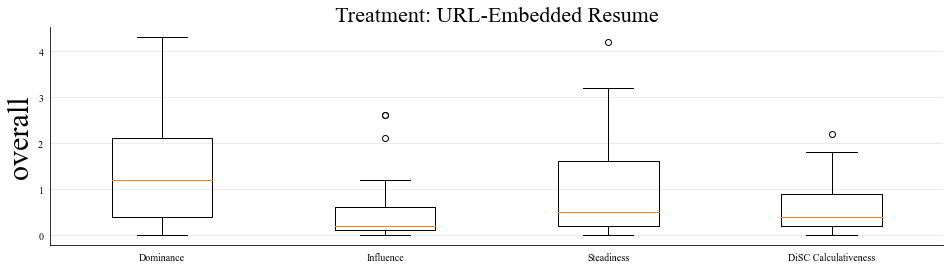

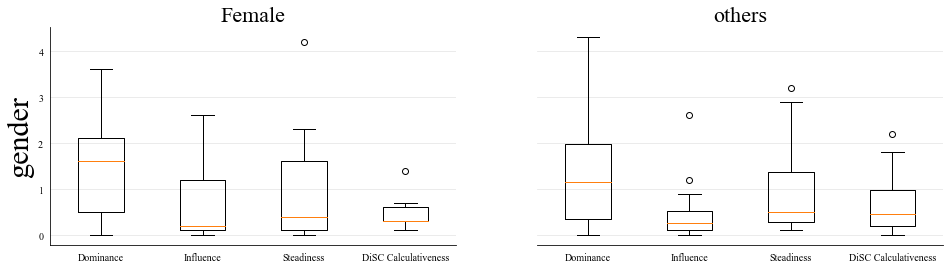

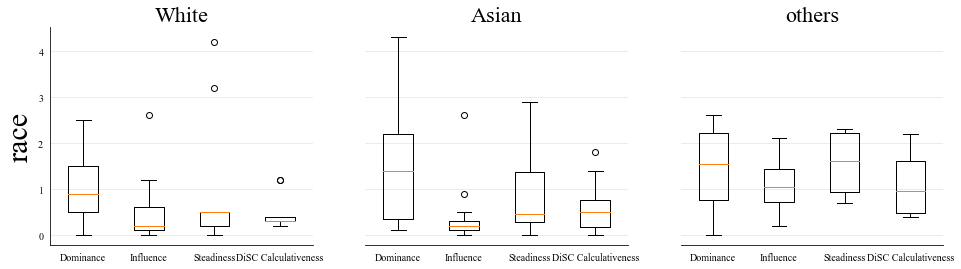

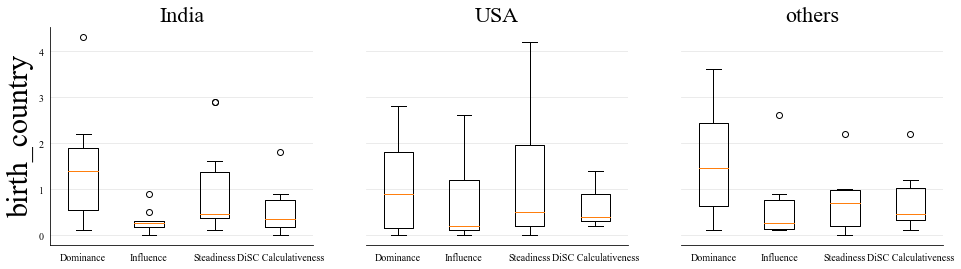

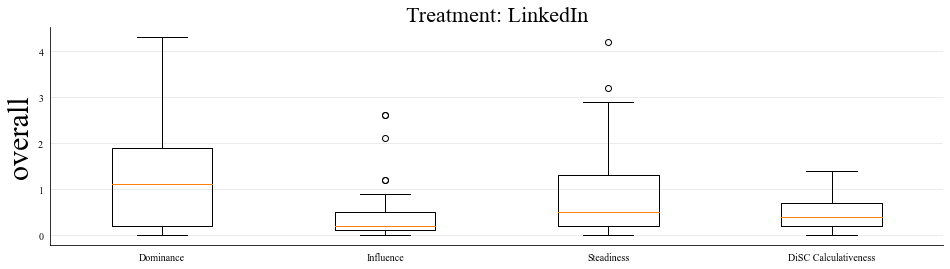

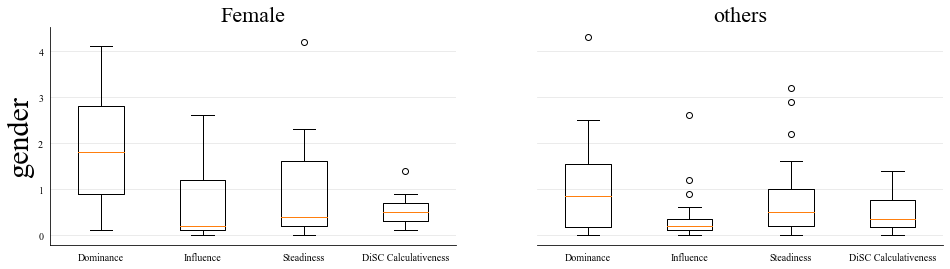

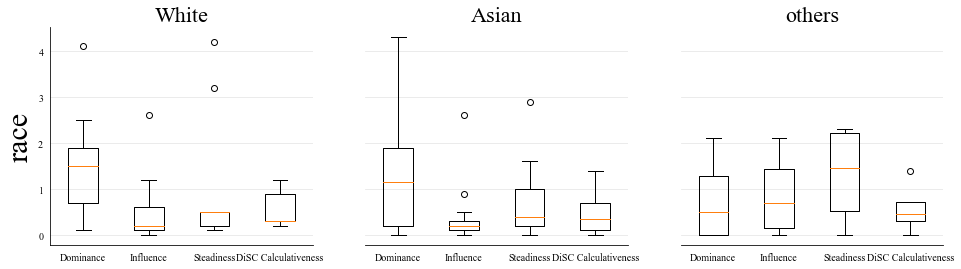

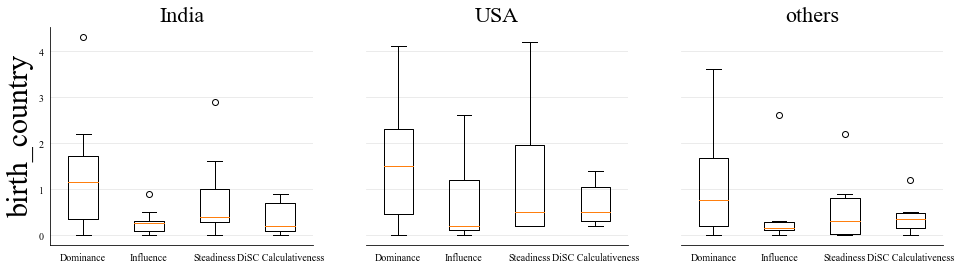

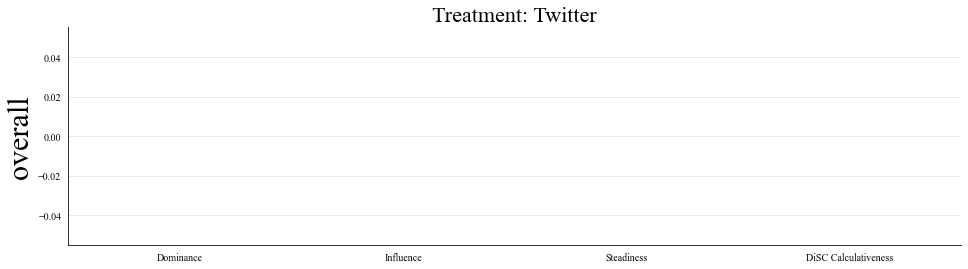

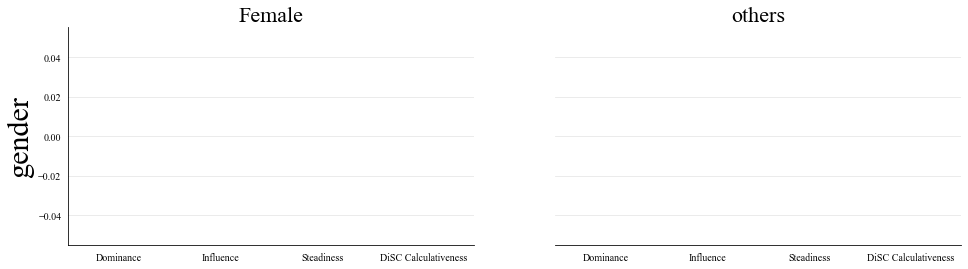

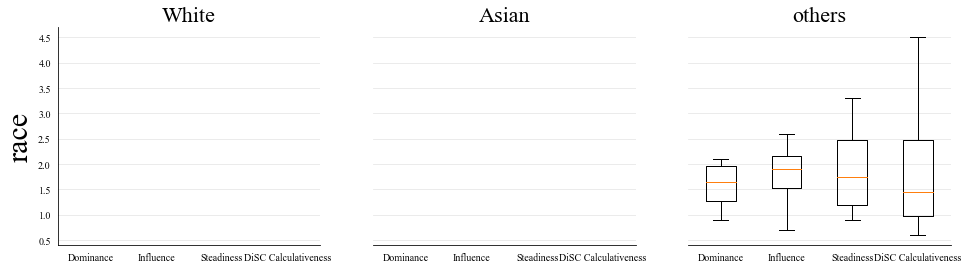

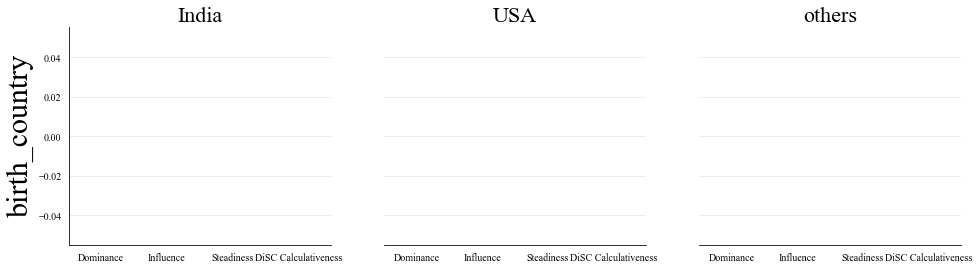

In [15]:
stability_audit.visualize_total_variation()

### Correlation between control and treatment as a measure of rank-order stability

In [16]:
spearman_ = stability_audit.compute_statistic(test=spearman)
spearman_

Dominance  Influence  \
De-Identified Resume overall__            correlation   0.558490   0.709694   
                                          p_value       0.001640   0.000016   
                     gender_Female        correlation   0.663884   0.393309   
                                          p_value       0.051182   0.294990   
                     gender_others        correlation   0.432831   0.782264   
...                                                          ...        ...   
Twitter              birth_country_India  p_value            NaN        NaN   
                     birth_country_USA    correlation        NaN        NaN   
                                          p_value            NaN        NaN   
                     birth_country_others correlation        NaN        NaN   
                                          p_value            NaN        NaN   

                                                       Steadiness  \
De-Identified Resume overall__            correlation    0.648556   
                                          p_value        0.000142   
                     gender_Female        correlation    0.798319   
                                          p_value        0.009897   
                     gender_others        correlation    0.616139   
...                                                           ...   
Twitter              birth_country_India  p_value             NaN   
                     birth_country_USA    correlation         NaN   
                                          p_value             NaN   
                     birth_country_others correlation         NaN   
                                          p_value             NaN   

                                                       DiSC Calculativeness  
De-Identified Resume overall__            correlation          8.959438e-01  
                                          p_value              5.129853e-11  
                     gender_Female        correlation          9.333333e-01  
                                          p_value              2.358998e-04  
                     gender_others        correlation          8.784349e-01  
...                                                                     ...  
Twitter              birth_country_India  p_value                       NaN  
                     birth_country_USA    correlation                   NaN  
                                          p_value                       NaN  
                     birth_country_others correlation                   NaN  
                                          p_value                       NaN  

[108 rows x 4 columns]

In [17]:
# User defined threshold
corr_threshold = 0.9

In [18]:
# If correlation is greater than the threshold, ADS is stable for that treatment
spearman_.loc[[i for i in spearman_.index if 'correlation' in i]] >= corr_threshold

Dominance  Influence  \
De-Identified Resume overall__            correlation      False      False   
                     gender_Female        correlation      False      False   
                     gender_others        correlation      False      False   
                     race_White           correlation      False      False   
                     race_Asian           correlation      False      False   
                     race_others          correlation      False       True   
                     birth_country_India  correlation      False      False   
                     birth_country_USA    correlation       True       True   
                     birth_country_others correlation      False      False   
De-Identified REsume overall__            correlation      False      False   
                     gender_Female        correlation      False      False   
                     gender_others        correlation      False      False   
                     race_White           correlation      False      False   
                     race_Asian           correlation      False      False   
                     race_others          correlation      False       True   
                     birth_country_India  correlation      False      False   
                     birth_country_USA    correlation       True       True   
                     birth_country_others correlation      False      False   
DOCX Resume          overall__            correlation      False      False   
                     gender_Female        correlation      False      False   
                     gender_others        correlation      False      False   
                     race_White           correlation      False      False   
                     race_Asian           correlation      False      False   
                     race_others          correlation      False       True   
                     birth_country_India  correlation      False      False   
                     birth_country_USA    correlation       True       True   
                     birth_country_others correlation      False      False   
URL-Embedded Resume  overall__            correlation      False      False   
                     gender_Female        correlation      False      False   
                     gender_others        correlation      False      False   
                     race_White           correlation      False      False   
                     race_Asian           correlation      False      False   
                     race_others          correlation      False      False   
                     birth_country_India  correlation      False       True   
                     birth_country_USA    correlation      False      False   
                     birth_country_others correlation      False      False   
LinkedIn             overall__            correlation      False      False   
                     gender_Female        correlation      False      False   
                     gender_others        correlation      False      False   
                     race_White           correlation      False      False   
                     race_Asian           correlation      False      False   
                     race_others          correlation      False      False   
                     birth_country_India  correlation      False       True   
                     birth_country_USA    correlation      False      False   
                     birth_country_others correlation      False      False   
Twitter              overall__            correlation      False      False   
                     gender_Female        correlation      False      False   
                     gender_others        correlation      False      False   
                     race_White           correlation      False      False   
                     race_Asian           correlation      False      False   
                     race_

### Wilcoxon signed rank test as a measure of locational stability

In [19]:
wilcoxon_ = stability_audit.compute_statistic(test=wilcoxon)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


### Correcting for multiple hypothesis testing 

In [20]:
pvals = wilcoxon_.loc[[i for i in wilcoxon_.index if 'p_value' in i]]

In [21]:
# User defined threshold
alpha_threshold = 0.05

In [22]:
# Using Benjamini-Hochberg correction here
corrected = stability_audit.multiple_hypothesis_correction(pvals, alpha = alpha_threshold, method='fdr_bh')

In [23]:
# Null hypothesis is that both samples are from the same distribution
# P_value less than threshold rejects the null hypothesis
# Hence, p_Value larger than threshold means that the ADS is stable for that treatment

corrected[stability_audit.score_names] > alpha_threshold

Dominance  Influence  \
De-Identified Resume overall__            p_value       True       True   
                     gender_Female        p_value       True       True   
                     gender_others        p_value       True       True   
                     race_White           p_value       True       True   
                     race_Asian           p_value       True       True   
                     race_others          p_value       True       True   
                     birth_country_India  p_value       True       True   
                     birth_country_USA    p_value       True       True   
                     birth_country_others p_value       True       True   
De-Identified REsume overall__            p_value       True       True   
                     gender_Female        p_value       True       True   
                     gender_others        p_value       True       True   
                     race_White           p_value       True       True   
                     race_Asian           p_value       True       True   
                     race_others          p_value       True       True   
                     birth_country_India  p_value       True       True   
                     birth_country_USA    p_value       True       True   
                     birth_country_others p_value       True       True   
DOCX Resume          overall__            p_value       True       True   
                     gender_Female        p_value       True       True   
                     gender_others        p_value       True       True   
                     race_White           p_value       True       True   
                     race_Asian           p_value       True       True   
                     race_others          p_value       True       True   
                     birth_country_India  p_value       True       True   
                     birth_country_USA    p_value       True       True   
                     birth_country_others p_value       True       True   
URL-Embedded Resume  overall__            p_value       True       True   
                     gender_Female        p_value       True       True   
                     gender_others        p_value       True       True   
                     race_White           p_value       True       True   
                     race_Asian           p_value       True       True   
                     race_others          p_value       True       True   
                     birth_country_India  p_value       True       True   
                     birth_country_USA    p_value       True       True   
                     birth_country_others p_value       True       True   
LinkedIn             overall__            p_value       True       True   
                     gender_Female        p_value       True       True   
                     gender_others        p_value       True       True   
                     race_White           p_value       True       True   
                     race_Asian           p_value       True       True   
                     race_others          p_value       True       True   
                     birth_country_India  p_value       True       True   
                     birth_country_USA    p_value       True       True   
                     birth_country_others p_value       True       True   
Twitter              overall__            p_value       True       True   
                     gender_Female        p_value       True       True   
                     gender_others        p_value       True       True   
                     race_White           p_value       True       True   
                     race_Asian           p_value       True       True   
                     race_others          p_value       True       True   
                     birth_country_India  p_value       True       True   
                     birth_country_USA    p_value       True       True   
 